In [1]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
from sympy import S, symbols, printing

from compilers import * 
from utils import *

import json

In [2]:
X = np.array([[0, 1],
     [1, 0]])
Z = np.array([[1, 0],
     [0, -1]])
Y = np.array([[0, -1j],
     [1j, 0]])
I = np.array([[1, 0],
     [0, 1]])
XX = np.kron(X, X) #tensor products between two Pauli's
XZ = np.kron(X, Z)
ZZ = np.kron(Z, Z)
ZX = np.kron(Z, X)
II = np.kron(I, I)
IX = np.kron(I, X)
XI = np.kron(X, I)
IZ = np.kron(I, Z)
ZI = np.kron(Z, I)
#List of Hamiltonian decomposition terms H_j for H = \sum_j h_j H_j
Hlist = np.array([XX, XZ, ZX, ZZ, IX, IZ, XI, ZI])
hj = [1.0, 2.0, -3.0, -4.0, -2.0, 1.0, 0.5, 0.25] #list of normalized coefficients

print(Hlist.shape)

hamiltonian_list = []
for i in range(len(hj)):
    hamiltonian_list.append(hj[i] * Hlist[i, :, :])
hamiltonian_list = np.array(hamiltonian_list)
pauli_hamiltonian = hamiltonian_list
print(hamiltonian_list.shape)
#print(hamiltonian_list)

(8, 4, 4)
(8, 4, 4)


In [3]:
# A simple function that computes the graph distance between two sites
def dist(site1, site2):
    distance_vec = site1 - site2
    distance = np.abs(distance_vec[0]) + np.abs(distance_vec[1])
    return distance

# A simple function that initializes a graph in the form of an np.array of coordinates 
def initialize_graph(x_sites, y_sites):
    coord_list = []
    for i in range(x_sites):
        for j in range(y_sites):
            coord_list.append([i,j])
    return np.array(coord_list)

#A funciton that initializes a Pauli operator in the correct space, acting on a specific qubit
def initialize_operator(operator_2d, acting_space, space_dimension):
    if acting_space>space_dimension:
        return 'error'
    for i in range(acting_space):
        operator_2d = np.kron(operator_2d, I)
    for j in range(space_dimension - acting_space-1):
        operator_2d = np.kron(I, operator_2d)
    return operator_2d

def graph_hamiltonian(x_dim, y_dim, rng_seed):
    np.random.seed(rng_seed)
    hamiltonian_list = []
    graph = initialize_graph(x_dim, y_dim)
    for i in range(x_dim*y_dim):
        for j in range(y_dim*x_dim):
            if i != j: #long range interaction
                alpha = np.random.normal()
                hamiltonian_list.append(alpha * 
                    np.matmul(initialize_operator(Z, i, x_dim*y_dim), initialize_operator(Z, j, x_dim*y_dim)) *
                        10.0**(-dist(graph[i], graph[j]))) 

            # if (dist(graph[i], graph[j])==1) and (i>j): #nearest neighbour interaction
            #     beta = np.random.normal()
            #     hamiltonian_list.append(beta * np.matmul(initialize_operator(Y, i, x_dim*y_dim), initialize_operator(Y, j, x_dim*y_dim)))
            
        gamma = np.random.normal()
        hamiltonian_list.append(4* gamma * initialize_operator(X, i, x_dim*y_dim))
                
    return np.array(hamiltonian_list)

In [9]:
graph_hamiltonian_list = graph_hamiltonian(6, 1, 1)
print(graph_hamiltonian_list.shape)

sim = CompositeSim(graph_hamiltonian_list, nb=10, state_rand=True, exact_qd=True, use_density_matrices=True, imag_time=True)
partition_sim(sim, "qdrift")


tstart = 1
tfinal = 100
tsteps = 20
times = np.geomspace(tstart, tfinal, tsteps)
#print(multi_infidelity_sample(sim, 1, exact_time_evolution_density(sim.unparsed_hamiltonian, 1, sim.initial_state), 40, 20))
epsilon_data=[]
for t in times:
    epsilon_data.append(sim_trace_distance(sim, time=t, iterations=1, nb=200))
    #inf_list, _ = zip(*multi_infidelity_sample(sim, t, exact_time_evolution(sim.unparsed_hamiltonian, t, sim.initial_state), iterations=1, nbsamples=1, mc_samples=1))
    #epsilon_data.append(statistics.mean(inf_list))

#exact_cost(sim, time = 0.005, nb=1, epsilon=0.001) #should set the gate count to zero or refresh them somewhere 

(36, 64, 64)


/Users/matthewpocrnic/Desktop/A1 Grad School Assignments/Master's Research/Simulation Code/Trotter-Qdrift-Simulation/utils.py:1079: RuntimeWarning: overflow encountered in multiply
  ret = evol_op * initial_rho * evol_op
/Users/matthewpocrnic/Desktop/A1 Grad School Assignments/Master's Research/Simulation Code/Trotter-Qdrift-Simulation/utils.py:1080: RuntimeWarning: invalid value encountered in true_divide
  return ret / np.trace(ret)


ValueError: array must not contain infs or NaNs

ValueError: x and y must have same first dimension, but have shapes (20,) and (11,)

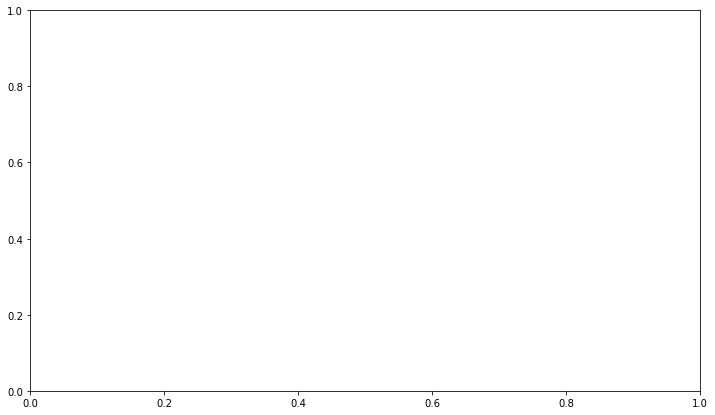

In [8]:
data = np.log10(epsilon_data)
log_times = np.log10(times)
plt.figure(figsize = (12, 7))
plt.plot(log_times, data, 'o-') 
plt.xlabel('log Time', size = 18)
plt.ylabel('log Trace Distance', size = 18)
plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15)

start_fit_points= 0 #declare the starting point to fit in the data
end_fit_points = -14

p = np.polyfit(log_times[start_fit_points: end_fit_points], data[start_fit_points: end_fit_points], 1)
f = np.poly1d(p)

t_new = np.linspace(log_times[start_fit_points], log_times[end_fit_points], 50)
y_new = f(t_new)

data = symbols("t")
poly = sum(S("{:6.2f}".format(v))*data**i for i, v in enumerate(p[::-1]))
eq_latex = printing.latex(poly)
plt.plot(t_new, y_new, 'r--', label="${}$".format(eq_latex))
plt.legend(fontsize= 22)

data = np.log10(epsilon_data)
start_fit_points1= 11 #declare the starting point to fit in the data
end_fit_points1 = -2
p1 = np.polyfit(log_times[start_fit_points1: end_fit_points1], data[start_fit_points1: end_fit_points1], 1)
f1 = np.poly1d(p1)

t_new1 = np.linspace(log_times[start_fit_points1], log_times[end_fit_points1], 50)
y_new1 = f1(t_new1)

data = symbols("t")
poly1 = sum(S("{:6.2f}".format(v))*data**i for i, v in enumerate(p1[::-1]))
eq_latex1 = printing.latex(poly1)

plt.plot(t_new1, y_new1, 'b--', label="${}$".format(eq_latex1))
plt.legend(fontsize= 22)
plt.show()